In [1]:
from hera_sim.visibilities import VisCPU, conversions#, HealVis#, VisGPU#, PRISim
from hera_sim import io
import numpy as np
import healpy
import matplotlib.pyplot as plt
import itertools
import copy
from pyuvsim.analyticbeam import AnalyticBeam
from pyuvdata import UVBeam
import uvtools
from multiprocessing import Pool
import emcee
import corner
from beams import PolyBeam
#import healvis as HEALVIS

/astro/samir/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/astro/samir/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/astro/samir/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/astro/samir/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STAT

In [2]:
dist = 14.6
ants = {}

for i in range(0, 4):
        ants.update([(i, (-3.*dist/2 + i*14.6, 0., 0.))])   
for i in range(4, 7):
        ants.update([(i, (-2.*dist/2 + (i-4)*14.6, -1.* np.sqrt(3) * dist/2, 0.))])   
for i in range(7, 10):
        ants.update([(i, (-2.*dist/2 + (i-7)*14.6, +1.* np.sqrt(3) * dist/2, 0.))])

Text(0, 0.5, 'y in metre')

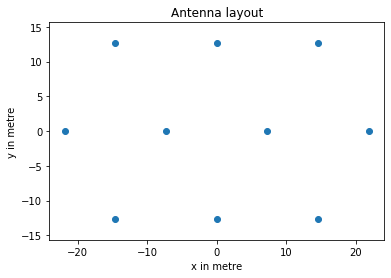

In [3]:
antscord = list(ants.values())[:]
antscord = np.array(antscord)

plt.scatter(antscord[:,0],antscord[:,1])
plt.axis('equal')
plt.title('Antenna layout')
plt.xlabel('x in metre')
plt.ylabel('y in metre')

In [4]:
#nfreqs = 60
nfreqs = 20
def myuvdata(ntimes=50, **kwargs): #160
    
    return io.empty_uvdata(
        nfreq = nfreqs,
        start_freq = 1.e8,
        channel_width = 0.2e8 / nfreqs,
        start_time=2458902.33333,
        integration_time = 40.,
        ntimes= ntimes,
        ants = ants,
        **kwargs
    )
uvdata = myuvdata()

In [5]:
uvdata.freq_array

array([[1.00e+08, 1.01e+08, 1.02e+08, 1.03e+08, 1.04e+08, 1.05e+08,
        1.06e+08, 1.07e+08, 1.08e+08, 1.09e+08, 1.10e+08, 1.11e+08,
        1.12e+08, 1.13e+08, 1.14e+08, 1.15e+08, 1.16e+08, 1.17e+08,
        1.18e+08, 1.19e+08]])

In [6]:
aa = np.genfromtxt('gleamegc.dat',usecols=(10,12,77,-5))
bb = aa[ (aa[:,2] >= 1.) & np.isfinite(aa[:,3])] # Fluxes more than 1 Jy

In [7]:
ra_dec = np.deg2rad(bb[:,0:2])
ra_dec.shape

(28739, 2)

In [8]:
freqs = np.unique(uvdata.freq_array)
freq0 = 1.e8

flux = (freqs[:,np.newaxis]/freq0)**bb[:,3].T*bb[:,2].T
flux.shape

(20, 28739)

In [9]:
# Best fit coeffcients for Chebyshev polynomials
coeff = np.array([ 2.35088101e-01, -4.20162599e-01,  2.99189140e-01, -1.54189057e-01,
        3.38651457e-02,  3.46936067e-02, -4.98838130e-02,  3.23054464e-02,
       -7.56006552e-03, -7.24620596e-03,  7.99563166e-03, -2.78125602e-03,
       -8.19945835e-04,  1.13791191e-03, -1.24301372e-04, -3.74808752e-04,
        1.93997376e-04, -1.72012040e-05])
spindex = -0.6975 #by power-law fitting of the width of Fagnoni beam at 100 and 200 MHz

In [10]:
from beams import PolyBeam, perturb_PolyBeam

In [11]:
pbmodel = perturb_PolyBeam(beam_coeffs=coeff, spectral_index = spindex, ref_freq=freq0, mainlobe_err=0., sidelobe_err=0.1, Nbeam=10)

Covariance of the parameters could not be estimated


In [12]:
simulator2 = VisCPU(
    uvdata = uvdata,
    beams = pbmodel,
    beam_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8 , 9],
    sky_freqs = freqs,
    point_source_pos = ra_dec,
    point_source_flux = flux,
    real_dtype = np.float64,
    complex_dtype = np.complex128,
    use_pixel_beams=False,
    bm_pix = 20
)

In [14]:
simulator2.simulate()

array([[[[ 4.25036938e+01+0.j        ],
         [ 4.10532411e+01+0.j        ],
         [ 3.96598557e+01+0.j        ],
         ...,
         [ 2.40865400e+01+0.j        ],
         [ 2.33241737e+01+0.j        ],
         [ 2.25885162e+01+0.j        ]]],


       [[[-1.81074530e+01-8.03786858j],
         [-1.75737102e+01-7.45548096j],
         [-1.70540042e+01-6.90439074j],
         ...,
         [-1.07869706e+01-1.43720546j],
         [-1.04562627e+01-1.20933664j],
         [-1.01344824e+01-0.99375225j]]],


       [[[-4.47933859e+00+8.07694269j],
         [-3.98930244e+00+8.09077831j],
         [-3.50238559e+00+8.07866068j],
         ...,
         [ 2.16049100e+00+5.30990052j],
         [ 2.37342818e+00+5.01530594j],
         [ 2.56288278e+00+4.71693448j]]],


       ...,


       [[[ 6.73098973e+00+0.j        ],
         [ 6.30143329e+00+0.j        ],
         [ 5.89994991e+00+0.j        ],
         ...,
         [ 2.23507358e+00+0.j        ],
         [ 2.09801952e+00+0.j        ]

In [15]:
visibility2 = simulator2.uvdata.get_data(1,3)

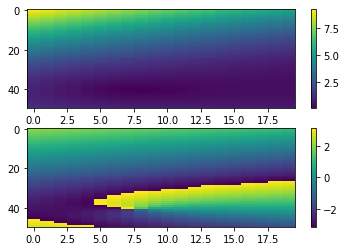

In [16]:
plt.figure()
plt.subplot(211); uvtools.plot.waterfall(visibility2, mode='abs'); plt.colorbar()
plt.subplot(212); uvtools.plot.waterfall(visibility2, mode='phs'); plt.colorbar()
plt.show()